# **Business Case in The Automobile Industry**

In this business case we will try to analyze the data leading up to the Volkswagen buyout of Porsche. We will compare what models describe the stock best (before and after each anouncement) and comment on the results. Additionally, I've defined another crucial date in the history of Volkswagen, the so called start of the diesel gate scandal in September 2015. 

**Note:** This code was written on Jupyter Notebook.  
**Language:** Python.  
**Packages:** numpy, pandas, scipy, statsmodels, pmdarima, yfinance, matplotlib.

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
#from arch import arch_model
import yfinance
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

**Load the data**

In [2]:
# we will scrape the data off the yahoo website
# some abbreviations for certain equities on the stock market are added: "VOM3.DE", "PAHE3.DE", "BMW.DE"
# the DE at the end indicates that this data was recorded from the German stock market
raw_data = yfinance.download(tickers = 'VOW3.DE, PAH3.DE, BMW.DE', interval = '1d', group_by = 'ticker',
                            auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
# create a copy of the dataset
df = raw_data.copy()

In [4]:
# we will define some key dates
# starting date
start_date = '2009-04-05' # this is the earliest date where we have recorded values for the stocks

# first official announcement - 49.9%
ann_1 = '2009-12-09' # on that date VW announced they owned 49.9% of Porsche

# second official announcement - 50.1%
ann_2 = '2012-07-05' # VW announced the purchase of the remaining 50.1% 

# since VW have the full ownership of Porsche we expect their values to move quite similarly after this point
# ending date
end_date = '2014-01-01'

# dieselgate
d_gate = '2015-09-20'

**Preprocess and examine the data**

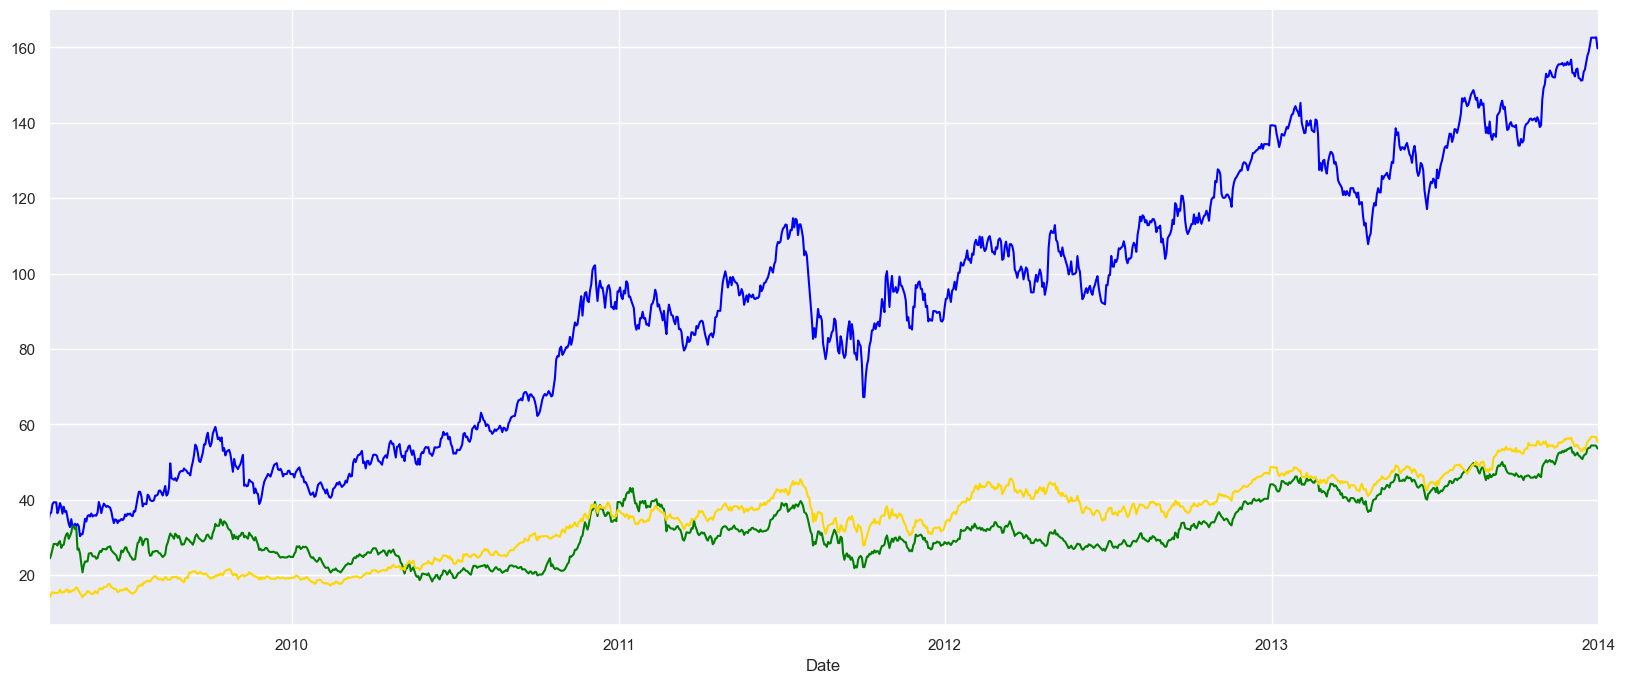

In [5]:
# extracting closing prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# creating returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# creating squared returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# extracting volume to calculate the number of purchases and sales each day
# the more a certain stock is being traded on a given day, the more likely it is for its price to fluctuate
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

# assigning the frequency and filling NA values
df = df.asfreq('b')
df = df.fillna(method = 'bfill')

# removing surplus data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

# we usually split the data into a training and a testing set
# but here we're examining a specific event in time, rather than trying to predict the future

# plotting the data
df['vol'][start_date:end_date].plot(figsize = (20,8), color = 'blue')
df['por'][start_date:end_date].plot(color = 'green')
df['bmw'][start_date:end_date].plot(color = 'gold')
plt.show()

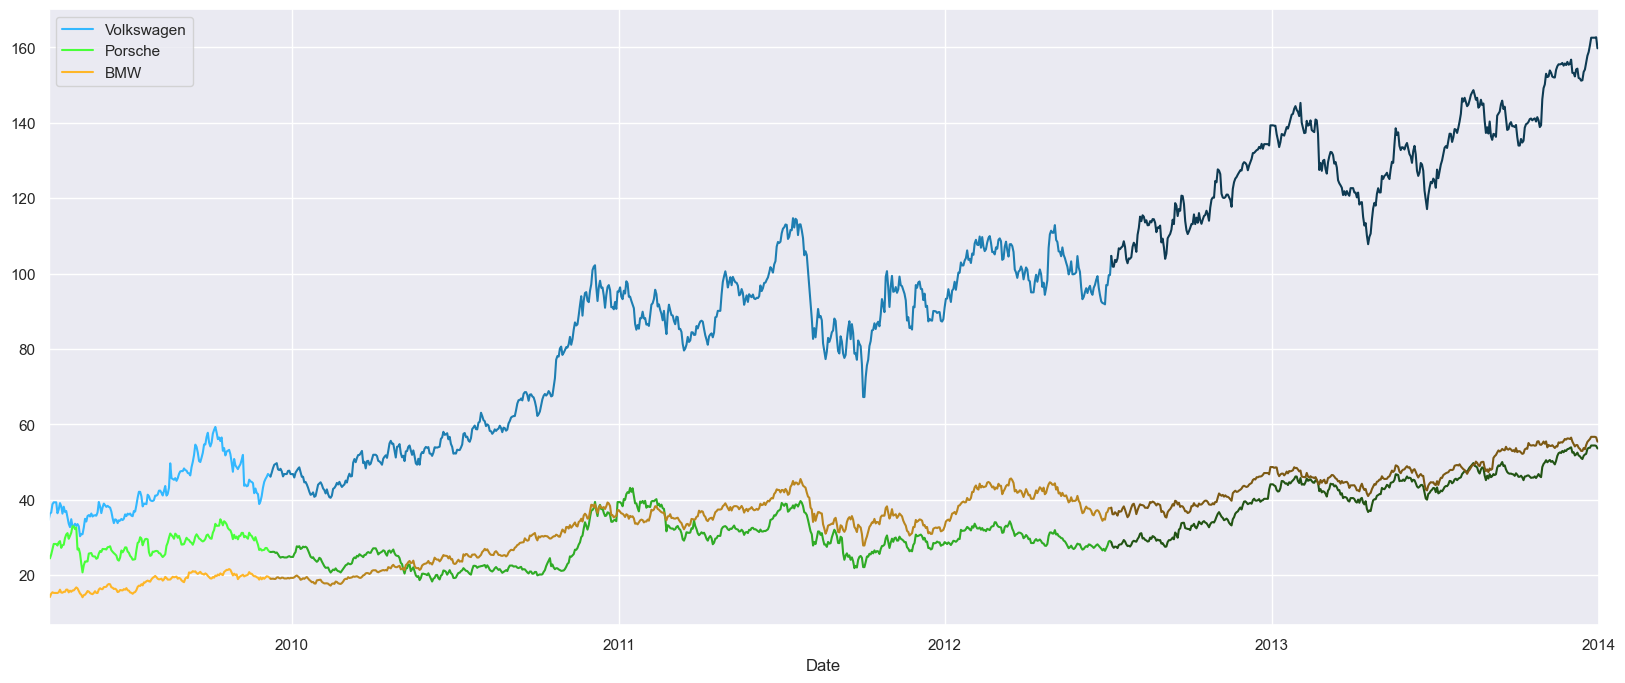

In [6]:
# we see similarities in the way the three time series move which indicates trends of the entire automobile industry market
# VW prices shift a lot more in magnitude after the third quarter of 2009 
# to see what's really happening we should separate the different intervals by color
# we'll go from lighter to darker colors of the same blue, green and gold

# shades of blue: "#33B8FF", "1E7EB2", "#0E3A52"
# shades of green: "#49FF3A", "#2FAB25", "#225414"
# shades of gold: "#FEB628", "#BA861F", "#7C5913"

df['vol'][start_date:ann_1].plot(figsize = (20,8), color = '#33B8FF')
df['por'][start_date:ann_1].plot(color = '#49FF3A')
df['bmw'][start_date:ann_1].plot(color = '#FEB628')

df['vol'][ann_1:ann_2].plot(color = '#1E7EB2')
df['por'][ann_1:ann_2].plot(color = '#2FAB25')
df['bmw'][ann_1:ann_2].plot(color = '#BA861F')

df['vol'][ann_2:end_date].plot(color = '#0E3A52')
df['por'][ann_2:end_date].plot(color = '#225414')
df['bmw'][ann_2:end_date].plot(color = '#7C5913')

# add a legend
plt.legend(['Volkswagen', 'Porsche', 'BMW'])
plt.show()

In [7]:
# prior to the first announcement we see that BMW and Porsche move in a similar fashion
# however, Volkswagen prices seem to be as twice as high
# afterwards, the gap seems to grow bigger and bigger
# the BMW numbers seem to be closer to the Porsche ones than VW
# to get a clear idea of how these numbers are similar to the one another we should take a look at the correlation
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date) + '\n')
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359546961066041
Volkswagen and BMW correlation: 	0.9799378252239842
Porsche and BMW correlation: 		0.805215791331745


In [8]:
# the correlation between Volkswagen and Porsche is higher than the one between Porsche and BMW
# this suggests that VW moves in a similar way to the market benchmark
# this is curious because BMV owns 100% of Porsche by the end of this time interval so shouldn't the correlation be much higher?
# to understand what's going on I examined the three intervals one by one
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1) + '\n')
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633583598453612
Volkswagen and BMW correlation: 	0.8427607473527862
Porsche and BMW correlation: 		0.6095038731258147


In [9]:
# we see much lower correlation all around with Porsche and BMW taking the biggest hit
# this suggests the stock prices for these brands weren't too similar before the start of the buyout
# a possible explanation for this is that Porsche's evaluation becomes heavily tied to that of VW
# then VW becomes a trend setter so all other companies have to adjust to it
# that way VW affects both VW and Porsche simultaneously, one directly and one indirectly
# let's examine what happens in the seond interval
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2) + '\n')
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428267759344749
Volkswagen and BMW correlation: 	0.9795942935437961
Porsche and BMW correlation: 		0.7042723405808664


In [10]:
# the new results show increase across all correlations
# this matches the expectation that Porsche and BMW correlation keeps increasing as VW grows as a market leader
# it also matches the expectation of VW Porsche interdependence increase as VW continues to buy Porsche shares
# the most interesting part here is the almost 98% correlation between VW and BMW
# if we take another look at the graph we can see that in that period VW stocks grow in value several times faster than the market benchmark
# however, since the market moves relatively the same way, VW becomes a sort of trend setter after the partial takover of Porsche
# let's change the intervals once again and find out what happens when VW fully buys Porsche
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date) + '\n')
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237098836514
Volkswagen and BMW correlation: 	0.9284447127608058
Porsche and BMW correlation: 		0.949411155604466


In [11]:
# we see a higher correlation between VW and Porsche than between VW and BMW
# this shows that the VW and Porsche are being recognized as a single entity and the prices of one directly affect the other
# however the highest correlation is the one between BMW and Porsche which is interesting considering they have no obvious link between them
# we can change the interval to include all the values from the ending date onwards
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1]) + '\n')
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2022-12-15 00:00:00

Volkswagen and Porsche correlation: 	0.8841741105510532
Volkswagen and BMW correlation: 	0.6503679299491606
Porsche and BMW correlation: 		0.7710297400276699


In [12]:
# we see that the correlation between Porsche and VW remains high but the other two are falling

**Best fitting models**

In [13]:
# let's examine how the VW trends change after the two anouncements
# for Volkswagen
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                           m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por', 'bmw']][ann_1:ann_2],
                           m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por', 'bmw']][ann_2:end_date],
                           m = 5, max_p = 5, max_q = 5)

In [14]:
# print the summary table of the first model
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -313.553
Date:                Thu, 15 Dec 2022   AIC                            637.106
Time:                        22:22:57   BIC                            653.015
Sample:                    04-06-2009   HQIC                           643.557
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6858      0.424      1.618      0.106      -0.145       1.517
por            0.3925      0.094      4.169      0.000       0.208       0.577
bmw            0.7060      0.335      2.107      0.035       0.049       1.363
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         1.9550      0.133     14.718      0.000       1.695       2.215
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# for the period priot to the 49.9% anouncement we see that an AR(1) model with a single lag and two exogenous variables is the best fit
# all coefficients apart from the intercept are significant so this is indeed a good fit
# we see that the estimate for the AR(1) ar.L1 (0.9633) value is very close to one
# this means we're sticking really close to the value of the last period with very little deviation
# let's print the summary table for the second model
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1044.485
Date:                Thu, 15 Dec 2022   AIC                           2094.970
Time:                        22:22:57   BIC                           2108.496
Sample:                    12-09-2009   HQIC                          2100.209
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7760      0.060     12.842      0.000       0.658       0.894
bmw            1.5801      0.074     21.269      0.000       1.435       1.726
sigma2         1.3170      0.054     24.532      0.000       1.212       1.422
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.42
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# the optimal model here is an integrated one
# print the summary table of the third model
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -587.155
Date:                Thu, 15 Dec 2022   AIC                           1180.311
Time:                        22:22:57   BIC                           1192.201
Sample:                    07-05-2012   HQIC                          1185.025
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.6868      0.056     30.369      0.000       1.578       1.796
bmw            0.8749      0.093      9.381      0.000       0.692       1.058
sigma2         1.1983      0.059     20.461      0.000       1.084       1.313
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.80
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# again the optimal model is an integrated one
# let's examine how the Porsche trends change after the two anouncements
mod_pr_pre_vol = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol', 'bmw']][start_date:ann_1],
                           m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol', 'bmw']][ann_1:ann_2],
                           m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol', 'bmw']][ann_2:end_date],
                           m = 5, max_p = 5, max_q = 5)

In [18]:
# print the summary table for the first model
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -219.737
Date:                Thu, 15 Dec 2022   AIC                            451.474
Time:                        22:23:09   BIC                            470.565
Sample:                    04-06-2009   HQIC                           459.216
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5562      0.363      1.533      0.125      -0.155       1.267
vol            0.1172      0.054      2.157      0.031       0.011       0.224
bmw            0.9170      0.165      5.558      0.000       0.594       1.240
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.6837      0.048     14.098      0.000       0.589       0.779
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.39
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# before the first announcement we see that an AR(2) model with two exogenous variables is the best fit
# print the summary table for the second model
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -558.077
Date:                Thu, 15 Dec 2022   AIC                           1126.153
Time:                        22:23:10   BIC                           1148.697
Sample:                    12-09-2009   HQIC                          1134.885
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1819      0.016     11.134      0.000       0.150       0.214
bmw            0.3449      0.048      7.200      0.000       0.251       0.439
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3090      0.010     32.415      0.000       0.290       0.328
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.51
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# after the second announcement we see a shift towards an integrated model (ARIMA(1,1,1))
# print the summary table for the third model
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -196.988
Date:                             Thu, 15 Dec 2022   AIC                            401.976
Time:                                     22:23:10   BIC                            417.830
Sample:                                 07-05-2012   HQIC                           408.261
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2261      0.013     16.876      0.000       0.200       0.252
bmw            0.2604      0.043      6.036      0.000       0.176       0.345
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1612      0.006     27.851      0.000       0.150       0.173
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# this time the model discovers a seasonal pattern which we haven't discovered before (SARIMAX(0,1,0)(0,0,1,5))
# this backs the notion that these trends are affected more by current events rather than pre-existing patterns

**Predictions for the future**

In [22]:
# we are going to take the best fitting models and forecast them into the future
# and compare the predictions (based on data before the announcement) to the actual values following it

*For Porsche*

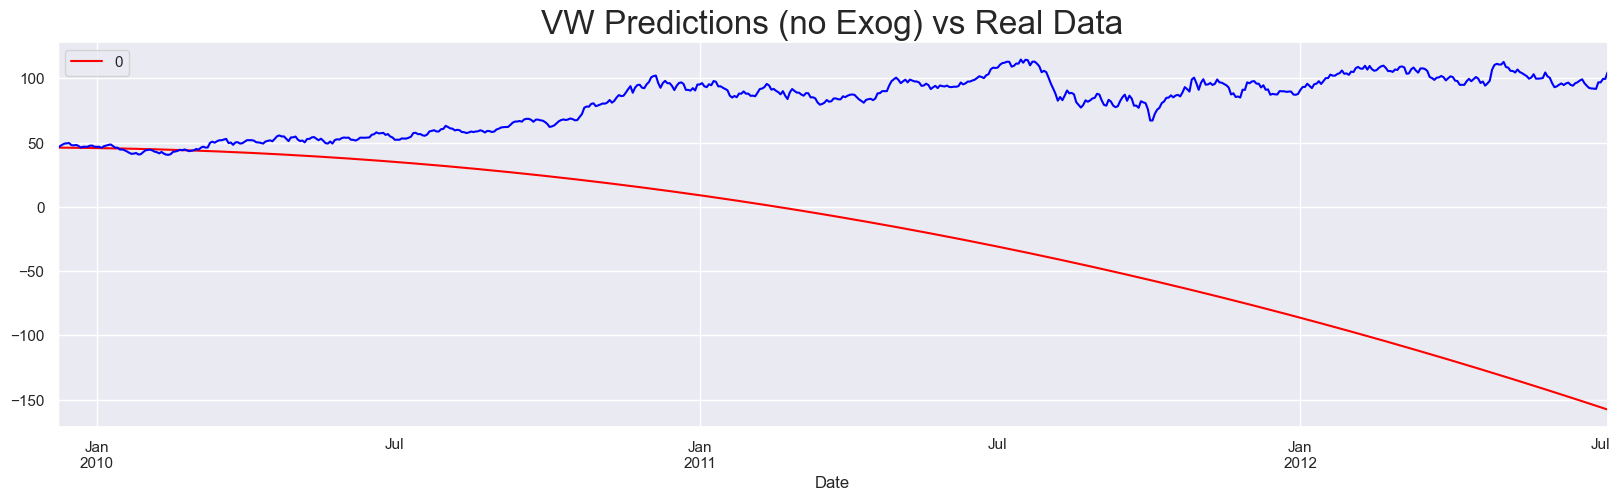

In [24]:
# fit the arima model before the first announcement
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], 
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

# next up, we'll create a dataframe where we store the predictions for the Volkswagen prices
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)

# plot the new column from announcement 1 to announcement 2
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = 'red')
df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (no Exog) vs Real Data', size = 24)
plt.show()

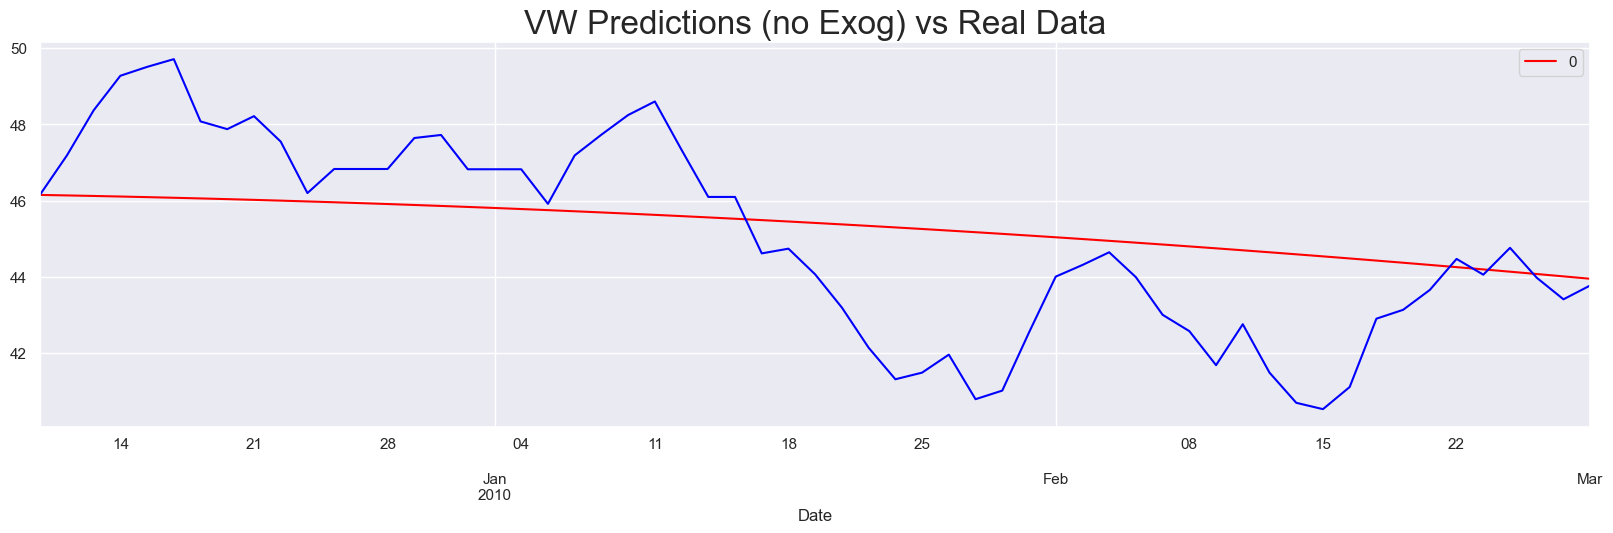

In [25]:
# the predictions seem to be very accurate over the first 2 to 4 months but they start to die off very quickly,
# while the actual data steadily go up
# also we notice that prices are going down below 0 which is impossible
# so how to explain the good predictions in the first months and the gap after
# first, I tried to zoom in the plot since the first announcement up to the first quarter 2010
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = 'red')
df.vol[ann_1:'2010-03-01'].plot(color = 'blue')
plt.title('VW Predictions (no Exog) vs Real Data', size = 24)
plt.show()

In [ ]:
# we see that the predictions weren't really close day by day but captured the entire trend over the entire period
# let's see what happens if we add exogenous variables

*For Volkswagen*

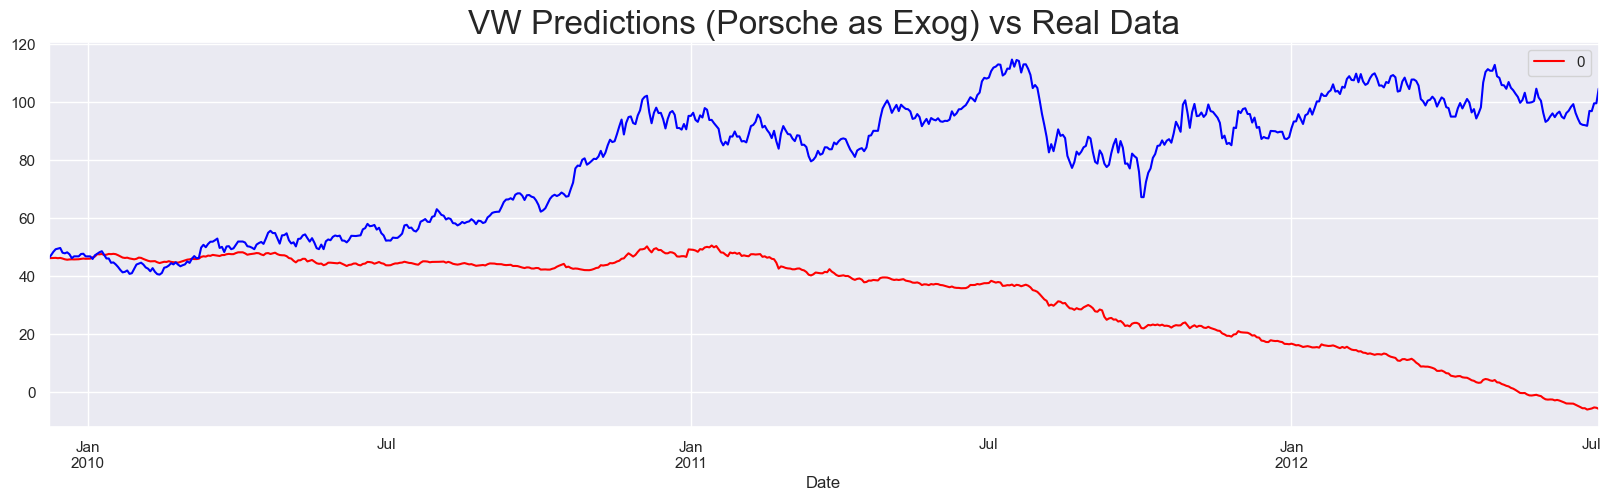

In [29]:
# fit the arima model before the first announcement
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

# next up, we'll create a dataframe where we store the predictions for the Volkswagen prices
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por']][ann_1:ann_2]),
                                                          index = df[ann_1:ann_2].index)

# plot the new column from announcement 1 to announcement 2
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = 'red')
df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (Porsche as Exog) vs Real Data', size = 24)
plt.show()

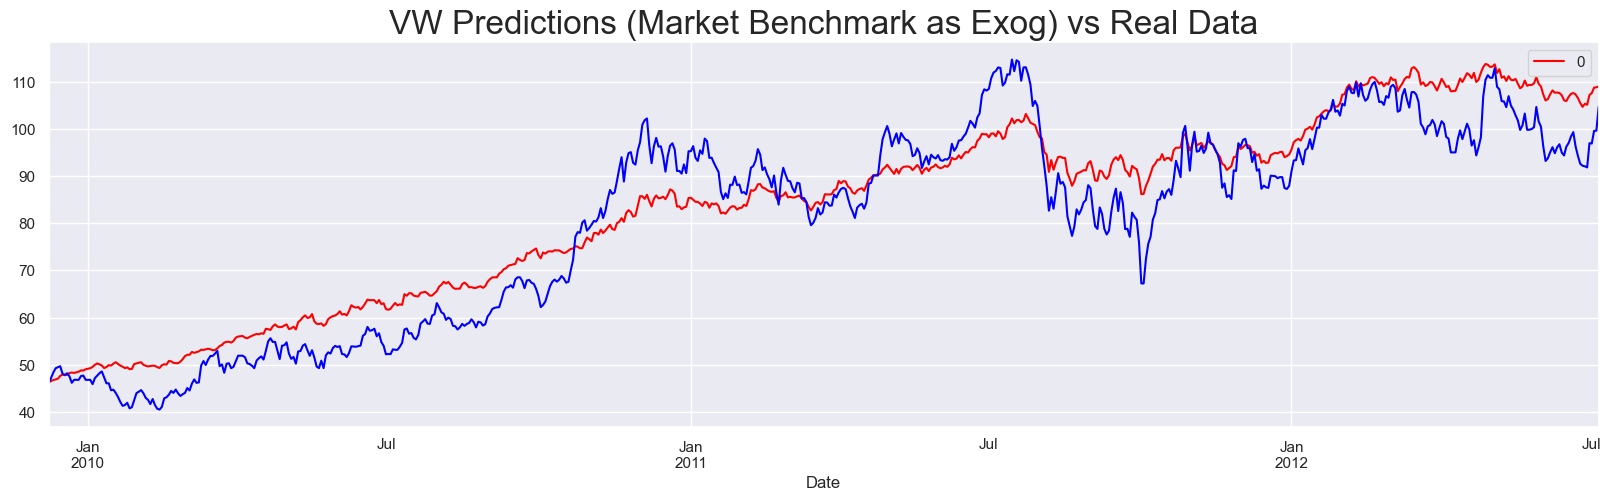

In [30]:
# as we can see, adding Porsche prices improves predictions but not substantially since we're moving far away after Q3 of 2010
# since Porsche is partially acquired, using a market benchmark would be a good idea, so I tried to switch the exogenous variable to BMW
# fit the arima model before the first announcement
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

# next up, we'll create a dataframe where we store the predictions for the Volkswagen prices
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                                                          index = df[ann_1:ann_2].index)

# plot the new column from announcement 1 to announcement 2
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = 'red')
df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (Market Benchmark as Exog) vs Real Data', size = 24)
plt.show()

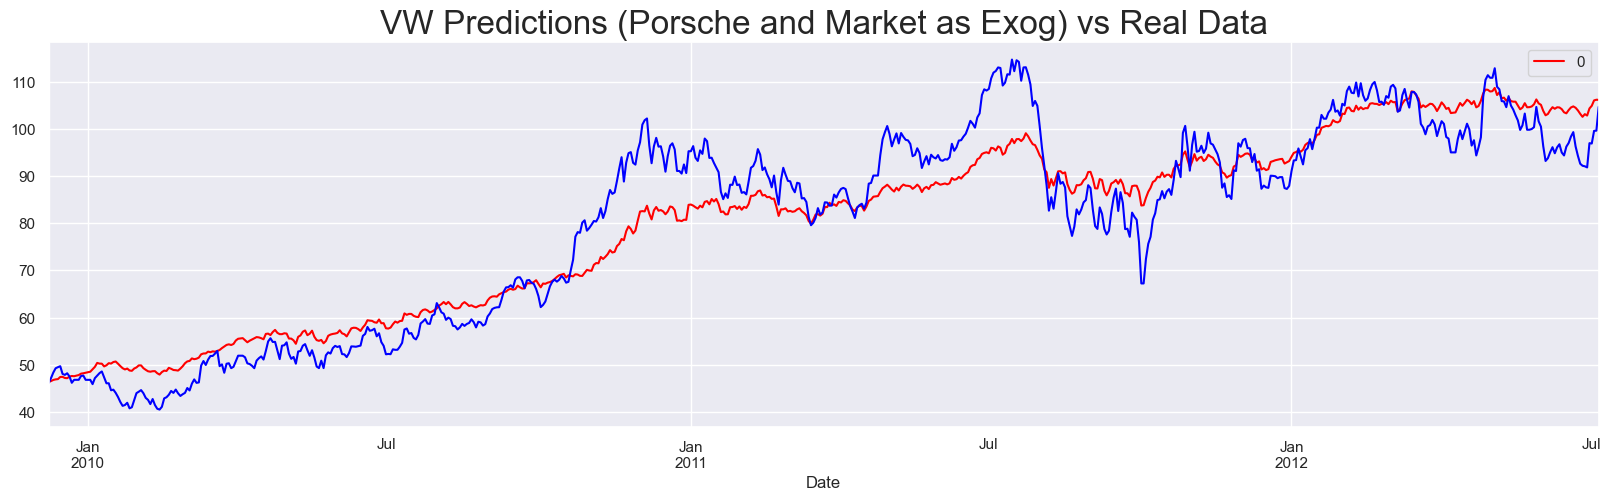

In [31]:
# with this small alteration we can see that the forecasts are lining up with the general trend over the entire period
# let's see what happend if we include both exogenous variables
# fit the arima model before the first announcement
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

# next up, we'll create a dataframe where we store the predictions for the Volkswagen prices
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por', 'bmw']][ann_1:ann_2]),
                                                          index = df[ann_1:ann_2].index)

# plot the new column from announcement 1 to announcement 2
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = 'red')
df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (Porsche and Market as Exog) vs Real Data', size = 24)
plt.show()

In [ ]:
# this graph is overall similar to the one when we include just the BMW prices
# however this one matches smaller shifts better and adjusts to big jumps and drops faster
# thus by adding a relevant value to the market benchmark we can improve predictions significantly
# therefore we can say that MAX models are less affected by real-life events because the other time series often reflect the changes in the market and help navigate the expectations